In [1]:
import numpy as np
import math
import statistics as stat
import random
import pandas as pd

from scipy.optimize import isotonic_regression
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import interp1d


from matchings import cross_bin_matching, same_bin_matching, immediate_neighbor_matching, max_weight_matching
from scipy.stats import norm
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches


lblue = (40/255,103/255,178/255)
sgreen = (46/255,139/255,87/255)
cred = (0.69411765, 0.01568627, 0.05490196)

In [2]:
def SCINT_test(X, Y, M, nperm=500):
    Del_X = np.array([X[i]-X[j] for (i,j) in M])
    Del_Y = np.array([Y[i]-Y[j] for (i,j) in M])
    
    D_S = np.einsum('ij, j, j -> i', 
                    (np.random.rand(nperm, len(M)) < .5), 
                    Del_X, 
                    Del_Y)
    
    return (1+np.sum(D_S <= 0))/(1+nperm)

In [3]:
data = pd.read_csv('~/Dropbox/Research/Jake-Rohan/COVID19MEXICO.csv')
data = data.dropna()
print(data.shape)
print(list(data.columns))

(1304796, 40)
['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA', 'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB', 'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL', 'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI']


In [4]:
comorbidities = ['HIPERTENSION', 'ASMA', 'DIABETES', 'CARDIOVASCULAR', 'OBESIDAD']
outcomes = ['CLASIFICACION_FINAL', 'RESULTADO_LAB', 'RESULTADO_ANTIGENO', 'UCI']


X = np.array(data["CLASIFICACION_FINAL"])
Y = np.array(data["HIPERTENSION"])
Z = np.array(data["EDAD"])

for nm in comorbidities:
    Y = np.array(data[nm])
    # print(np.unique(Y), data[nm].value_counts())

for nm in outcomes:
    X = np.array(data[nm])
    print(np.unique(X), data[nm].value_counts())


[1 2 3 4 5 6 7] CLASIFICACION_FINAL
7    754312
3    426948
6    110634
1      7934
5      4705
4       237
2        26
Name: count, dtype: int64
[ 1  2  3  4 97] RESULTADO_LAB
97    1002316
2      232649
1       51722
4       17431
3         678
Name: count, dtype: int64
[ 1  2 97] RESULTADO_ANTIGENO
2     622045
1     390577
97    292174
Name: count, dtype: int64
[ 1  2 97 99] UCI
97    1161656
2      137757
1        5121
99        262
Name: count, dtype: int64


In [98]:
df = data[data['HIPERTENSION'] != 98]
df = df[df['UCI'] != 97]
df = df[df['UCI'] != 99]
df = df[df['EDAD'] >= 20]

X = 2-np.array(df["UCI"]) # presence of covid RESULTADO_ANTIGENO
Y = 2-np.array(df["HIPERTENSION"]) # hypertension
Z = np.array(df["EDAD"]) # age

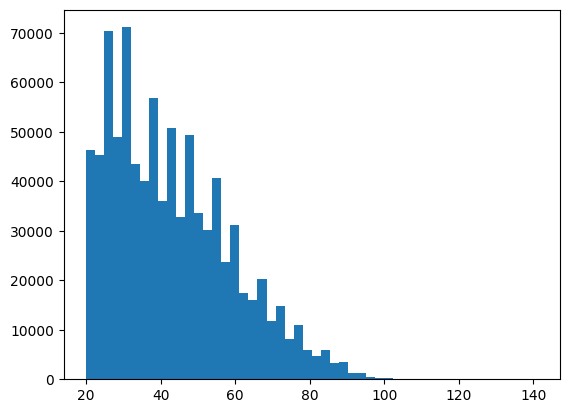

In [6]:
plt.hist(Z, bins=50)
plt.show()

In [7]:
len(Z)

877213

In [8]:
# n = len(Z)
# K = n//15
# M_cb = cross_bin_matching(Y, Z, K)


In [99]:
df['HYPERTENSION'] = 2-df['HIPERTENSION']
df['RESULT'] = 2-df['UCI']

In [101]:
np.mean(df['RESULT'])

0.03168343304033956

<Axes: xlabel='EDAD', ylabel='RESULT'>

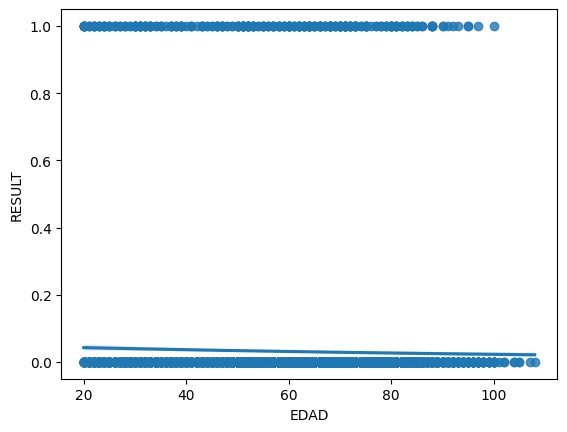

In [100]:
import seaborn as sns
sns.regplot(x="EDAD", y="RESULT", data=df.iloc[np.random.choice(len(Z), 10000, replace=False)], logistic=True)

In [11]:
# sns.regplot(x="EDAD", y="HYPERTENSION", data=df.iloc[np.random.choice(len(Z), 10000, replace=False)], logistic=True)

# Train-test Split

In [12]:
N = len(Z)
N

877213

In [25]:
Itr, Ite = np.array_split(np.random.permutation(N), 2)
ntr, nte = len(Itr), len(Ite)

In [26]:
Xtr, Xte = X[Itr], X[Ite]
Ytr, Yte = Y[Itr], Y[Ite]
Ztr, Zte = Z[Itr], Z[Ite]

# Train a model for $P_{X\mid Z}$

In [27]:
o = np.argsort(Ztr)

prob = isotonic_regression(Xtr[o]).x

## TODO - this may not work exactly as intended but we can estimate mu however we want
f = interp1d(Ztr[o], 
             prob, 
             kind='next',
             assume_sorted=True,
             fill_value='extrapolate')

mu_hat = f(Zte)
X_te = (np.random.rand(nte) <= mu_hat)*1

# Run tests

In [30]:
M_nbhd = immediate_neighbor_matching(Yte, Zte)
2*len(M_nbhd), nte

(395978, 438606)

In [31]:
SCINT_test(Xte, Yte, M_nbhd), SCINT_test(X_te, Yte, M_nbhd)

(0.001996007984031936, 0.8702594810379242)

In [28]:
K = nte // 100
M_cb = cross_bin_matching(Yte, Zte, K, binary=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:00<00:00, 13916.09it/s]


In [29]:
SCINT_test(Xte, Yte, M_cb), SCINT_test(X_te, Yte, M_cb)

(0.001996007984031936, 0.8502994011976048)

In [32]:
np.all([Zte[i] <= Zte[j] for (i, j) in M_cb])

True

# Maximum weight matching

Assume $X$ is binary. Let $W=(Y,Z)$ and $\mu(W) = \mathbb{P}\{X=1\mid W\}$. Given $W_i,W_j$ difference $X_i-X_j$ has distribution

$$X_i-X_j = \begin{cases} 1 & \text{w.p. } \mu(W_i)(1-\mu(W_j)) \\ -1 & \text{w.p. } (1-\mu(W_i))\mu(W_j) \\ 0 &\text{o.w.}\end{cases}.$$
Its mean and variance are
\begin{align*}
E_{ij} 
&= \mathbb{E}[X_i-X_j|W_i,W_j] \\
&= \mu(W_i)-\mu(W_j) \\
V_{ij} 
&= \text{Var}[X_i-X_j|W_i,W_j] \\
&= \mu(W_i)(1-\mu(W_i)) + \mu(W_j)(1-\mu(W_j))
\end{align*}

 

In [42]:
fs = []
mu_W = np.zeros(nte)
for y in [0, 1]:
    inds = (Ytr==y)
    o = np.argsort(Ztr[inds])

    prob = isotonic_regression(Xtr[inds][o]).x

    ## TODO - this may not work exactly as intended but we can estimate mu however we want
    g = interp1d(Ztr[inds][o], 
                 prob, 
                 kind='next',
                 assume_sorted=True,
                 fill_value='extrapolate')
    fs.append(g)
    
    inds_te = (Yte==y)
    mu_W[inds_te] = g(Zte[inds_te])
#     X_te = (np.random.rand(nte) <= mu_hat)*1

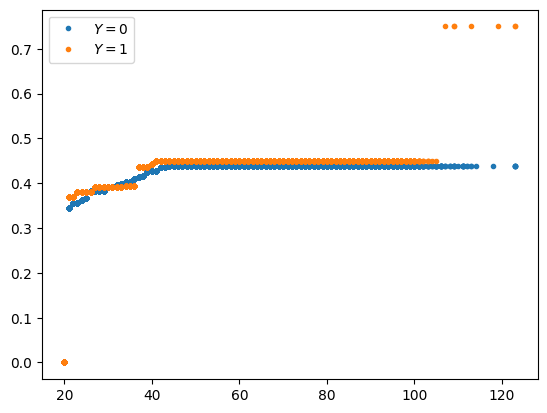

In [47]:
o = np.argsort(Zte)
for y in [0,1]:
    inds_te = (Yte==y)
    plt.plot(Zte[inds_te], mu_W[inds_te], '.', label='$Y=%d$'%y)
plt.legend()
plt.show()

In [88]:
nsub = 5000

sub = np.random.choice(nte, nsub, replace=False)

Xsub = Xte[sub]
Ysub = Yte[sub]
Zsub = Zte[sub]
mu_Wsub = mu_W[sub]

o = np.argsort(Zsub)

Xsub_ = Xsub[o]
Ysub_ = Ysub[o]
Zsub_ = Zsub[o]
mu_Wsub_ = mu_Wsub[o]

In [89]:

import networkx as nx

window = 20
G = nx.Graph()
for j in range(window,nsub):
    for i in range(j-window, j):
        e = (mu_Wsub_[i]-mu_Wsub_[j])
        if e > 0:
            v = (mu_Wsub_[i]*(1-mu_Wsub_[i]) + mu_Wsub_[j]*(1-mu_Wsub_[j]))
            G.add_edge(i, j, weight=e**2/v)


In [90]:
len(G.edges)

9252

In [91]:
M0 = nx.max_weight_matching(G)
M = []
for (i, j) in M0:
    M.append((min(i,j), max(i,j)))

In [92]:
SCINT_test(Xsub_, Ysub_, M, nperm=1000)#, SCINT_test(X_te, Yte, M_nbhd)

0.07492507492507493

In [93]:
1/501

0.001996007984031936